In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='Paired')

In [179]:
def load_prices(path):
    df = pd.read_csv(path)
    df['Data'] = pd.to_datetime(df['Data'])
    df = df.set_index('Data').sort_index()
    return df['Zamkniecie']

def daily_returns(prices):
    '''Liczy dzienne zwroty proste.'''
    return prices.pct_change().dropna(how='all')

def average_return(daily_returns, trading_days):
    '''Liczy średni zwrot w skali roku.'''
    return (1 + daily_returns.mean()) ** trading_days - 1

def cumulative_returns(daily_returns):
    '''Liczy skumulowaną stopę zwrotu dla dziennych stóp zwrotu.'''
    return (1 + daily_returns).cumprod() - 1

def volatility(daily_returns, trading_days):
    '''Liczy roczną zmienność na podstawie dziennych zwrotów.'''
    return daily_returns.std(ddof=1) * np.sqrt(trading_days)

def sharpe_ratio(daily_returns, risk_free_rate, trading_days):
    '''Liczy roczny wskaźnik Sharpe'a dla dziennych prostych zwrotów.'''
    daily_risk_free_rate = (1 + risk_free_rate) ** (1 / trading_days) - 1
    return ((daily_returns.mean() - daily_risk_free_rate) / daily_returns.std(ddof=1)) * np.sqrt(trading_days)

In [180]:
risk_free_rate = 0.0595 # https://www.obligacjeskarbowe.pl/oferta-obligacji/obligacje-3-letnie-tos/tos0128/
trading_days = 252

In [181]:
spx = load_prices('https://raw.githubusercontent.com/kornelia-kozaczewska/portfolio_analysis/refs/heads/main/data/%5Espx_d.csv')
ibca = load_prices('https://raw.githubusercontent.com/kornelia-kozaczewska/portfolio_analysis/refs/heads/main/data/ibca_de_d.csv')
mwig40 = load_prices('https://raw.githubusercontent.com/kornelia-kozaczewska/portfolio_analysis/refs/heads/main/data/mwig40tr_d.csv')

usdpln = load_prices('https://raw.githubusercontent.com/kornelia-kozaczewska/portfolio_analysis/refs/heads/main/data/usdpln_d.csv')
eurpln = load_prices('https://raw.githubusercontent.com/kornelia-kozaczewska/portfolio_analysis/refs/heads/main/data/eurpln_d.csv')

In [182]:
usdpln = usdpln.reindex(spx.index, method='ffill')
eurpln = eurpln.reindex(ibca.index, method='ffill')

spx_pln = spx * usdpln
ibca_pln = ibca * eurpln

spx_pln = spx_pln.reindex(mwig40.index, method='ffill')
ibca_pln = ibca_pln.reindex(mwig40.index, method='ffill')

In [183]:
portfolio_60_40_PLN = ibca_pln * .6 + mwig40 * .4
portfolio_60_40_PLN_US = ibca_pln * .6 + mwig40 * .2 + spx_pln * .2

portfolio_60_40_PLN.name = 'PL_60_40'
portfolio_60_40_PLN_US.name = 'PL_US_60_40'

portfolios = pd.concat([portfolio_60_40_PLN, portfolio_60_40_PLN_US], axis=1)
returns_pln = daily_returns(portfolios)

In [ ]:
avg = average_return(returns_pln, trading_days)
cumulative = cumulative_returns(returns_pln).iloc[-1]
vol = volatility(returns_pln, trading_days)
sharpe = sharpe_ratio(returns_pln, risk_free_rate, trading_days)


summary = pd.DataFrame({
    'Średni zwrot roczny (%)': (avg * 100).round(3),
    'Skumulowany zwrot (%)': (cumulative * 100).round(3),
    'Zmienność roczna (%)' : (vol * 100).round(3),
    'Sharpe roczny': sharpe.round(3)
})
summary


,Średni zwrot roczny (%),Skumulowany zwrot (%),Zmienność roczna,Sharpe roczny
PL_60_40,26.584,55.978,14.699,1.211
PL_US_60_40,19.389,39.805,12.377,0.965


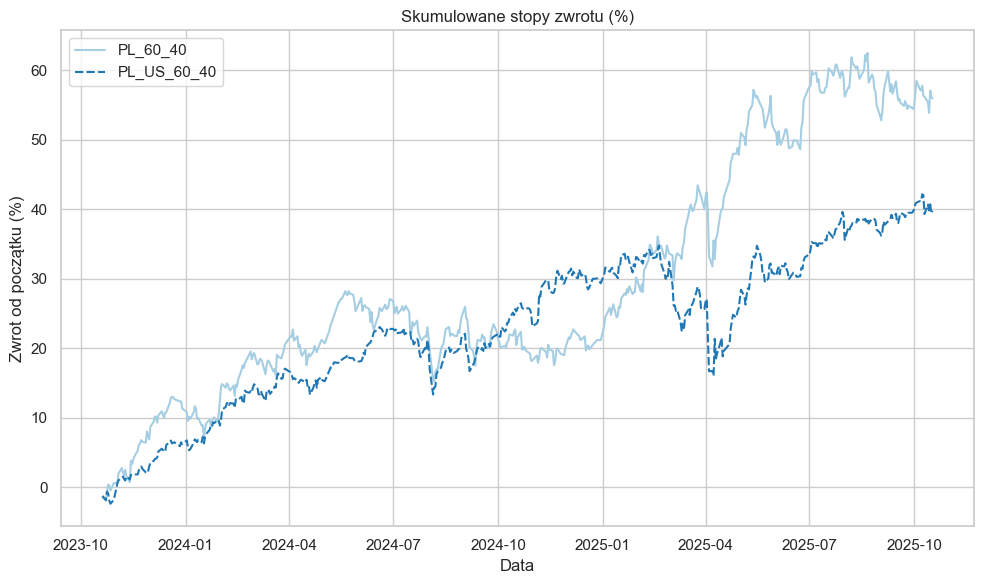

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=cumulative_returns(returns_pln) * 100)
plt.title('Skumulowane stopy zwrotu (%)')
plt.xlabel('Data')
plt.ylabel('Zwrot od początku (%)')
plt.tight_layout()
plt.show()